Notebook elaborado para estudar as principais transformações do campo potencial aplicadas ao método magnetométrico.
Criado para a disciplina Geofísica II da Universidade Federal de Uberlândia.
O uso e a reprodução são livres para fins educacionais, pede-se apenas a citação da fonte.

[![License: GPL v3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0)

Esta demonstração utiliza os códigos de transformação de campo potencial implementados no pacote *open source* [fatiando (v0.5)](https://github.com/fatiando/fatiando) (UIEDA; OLIVEIRA Jr; BARBOSA, 2013), distribuído sob os termos da [licença BSD-3](https://github.com/fatiando/fatiando/blob/master/LICENSE.txt). Não foram feitas modificações nos códigos utilizados.

Esta demonstração utiliza a modelagem de dados gravimétricos implementados no pacote *open source* [SimPEG v.14.3](https://github.com/simpeg/simpeg) (COCKETT et al., 2015), distribuído sob os termos da [licença MIT](https://github.com/simpeg/simpeg/blob/master/LICENSE). Não foram feitas modificações nos códigos utilizados.


Prof. Dr. Emerson Rodrigo Almeida<br>
Universidade Federal de Uberlândia<br>
Instituto de Geografia - Curso de Geologia<br>
emerson.almeida@ufu.br<br>

<p>&nbsp;</p>
Última modificação: 25/03/2021

---

**Referências:**

UIEDA, L.; OLIVEIRA Jr, V. C.; BARBOSA, V. C. F. Modeling the Earth with Fatiando a Terra. **Proceedings of the 12th Python in Science Conference**, p. 91 - 98, 2013.

COCKETT, R.; KANG, S.; HEAGY, L. J.; PIDLISECKY, A.; OLDENBURG, D. W. SimPEG: An open source framework for simulation and gradient based parameter estimation in geophysical applications. **Computers & Geosciences**, v.85, Part A, p. 142-154, 2015.

# Instruções iniciais

Neste notebook você irá visualizar a anomalia Bouguer em regiões específicas do mundo. Para isto leia atentamente as instruções apresentadas antes de cada célula e execute-as uma a uma, para acompanhar o processo corretamente.

Não se preocupe em compreender o código em si, não é obrigatório que você conheça a programação para obter e interpretar os resultados da demonstração. Mesmo assim, sinta-se livre caso queira perguntar qualquer coisa para aprender mais sobre o código e sua elaboração.

<p>&nbsp;</p>

### Passo 01 - Preparação

Primeiramente vamos preparar o ambiente para a execução da demonstração. Será preciso instalar o [SimPEG](https://simpeg.xyz/), que é um pacote open source para modelagem de dados geofísicos. Se você estiver executando este notebook pelo Binder ou pelo Colab execute a célula abaixo para instalar o SimPEG remotamente. Se preferir, pode instalar o pacote diretamente no seu computador ([instruções aqui](https://docs.simpeg.xyz/content/basic/installing.html)) e excluir a célula, porém é recomendável que faça isso **SOMENTE** se você já tiver familiaridade com este tipo de procedimento para evitar qualquer problema.

Você pode executar o código na célula clicando sobre ela e em seguida clicando no botão **RUN** na barra do Jupyter Notebook ou pressionando as teclas **SHIFT+ENTER** no seu teclado. Se você preferir executar este notebook localmente, no seu computador, então exclua a célula abaixo para não afetar a sua instalação.

# importa e instala o SimPEG - Célula exclusiva para execução em ambiente remoto
# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/04-magnetics/plot_2a_magnetics_induced.html

!git clone https://github.com/simpeg/simpeg
%cd simpeg
!pip install -r requirements.txt
!python setup.py install

Agora importe os módulos e defina as funções que precisaremos no decorrer da demonstração. A célula abaixo contém as funções utilizadas nos cálculos e as funções utilizadas para gerar as figuras. Execute-a uma vez antes de executar qualquer outra parte do código e **não altere nada no código apresentado na célula** para não criar problemas na execução do código.

<p>&nbsp;</p>

**Importante!** Nem todas as células irão retornar algum tipo de mensagem ou figura após a execução. Isto é normal e não significa que a execução tenha falhado. Perceba o símbolo **In [   ]:** próximo ao canto superior esquerdo de cada célula. Ao iniciar a execução de uma delas você verá um asterisco ($*$) aparecer dentro dos colchetes. Você saberá que a execução ocorreu sem problemas quando o $*$ dentro dos colchetes for substituído por um número e nenhuma mensagem de erro aparecer abaixo da célula executada.

In [1]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc
from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG import maps
from SimPEG.potential_fields import magnetics
from SimPEG import utils, data

from copy import deepcopy
import fatiando.gravmag.transform as tr


class modelo():
    
    """
    Define as dimensões, topografia e malha de tensores do modelo
    """
    
    def __init__(self, par_x, par_y, par_z, suscep_bg, topografia=None):
        
        """
        par_x:    parâmetros de comprimento e discretização do eixo x do modelo
        par_y:    parâmetros de comprimento e discretização do eixo y do modelo
        par_z:    parâmetros de comprimento e discretização do eixo z do modelo
        rho_bg:   densidade do background homogêneo
        """
        
        # cria os eixos x, y e z do modelo
        self.xx_m = np.linspace(-1 * par_x[0]/2, par_x[0]/2, 1 + int(par_x[0]/par_x[1]))
        self.yy_m = np.linspace(-1 * par_y[0]/2, par_y[0]/2, 1 + int(par_y[0]/par_y[1]))
        self.zz_m = np.linspace(0.0, par_z[0], 1 + int(par_z[0]/par_z[1]))
        
        
        # densidade das rochas do background - é zero porque o modelo vai considerar só
        # o contraste, não o valor absoluto
        self.suscep_background = suscep_bg
        
        
        # Define a topografia do modelo
        [x_topo, y_topo] = np.meshgrid(self.xx_m, self.yy_m)
        if topografia=='default':
            z_topo = -15.0 * np.exp(-(x_topo ** 2 + y_topo ** 2) / 80 ** 2)

        elif not topografia:
            z_topo = np.zeros((len(self.yy_m), len(self.xx_m)))

        x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
        self.xyz_topo = np.c_[x_topo, y_topo, z_topo]


        # Define a malha de tensores em células de tamanho regular
        dx = self.xx_m[1]-self.xx_m[0]
        dy = self.yy_m[1]-self.yy_m[0]
        dz = self.zz_m[1]-self.zz_m[0]

        nx = int((np.max(self.xx_m)-np.min(self.xx_m))/dx)
        ny = int((np.max(self.yy_m)-np.min(self.yy_m))/dy)
        nz = int((np.max(self.zz_m)-np.min(self.zz_m))/dz)
        
        hx = [(dx, nx)]
        hy = [(dy, ny)]
        hz = [(dz, nz)]

        self.mesh = TensorMesh([hx, hy, hz], 'CCN')
        
        # Find the indices for the active mesh cells (e.g. cells below surface)
        self.ind_active = surface2ind_topo(self.mesh, self.xyz_topo)

        # Define mapping from model to active cells. The model consists of a value for
        # each cell below the Earth's surface.
        nC = int(self.ind_active.sum())
        self.model_map = maps.IdentityMap(nP=nC)

        # Define o modelo com a susceptibilidade do background. Models in SimPEG are vector arrays.
        self.model = self.suscep_background * np.ones(nC)
        
        
    def insere_esfera(self, chi, x, y, z, raio):
        ind_sphere = model_builder.getIndicesSphere([x, y, (z-raio)], raio, self.mesh.gridCC)
        ind_sphere = ind_sphere[self.ind_active]
        self.model[ind_sphere] = chi
        
        
    def insere_bloco(self, chi, vertices):
        """
        vertices: lista de tuplas -> [(xi, xf),(yi, yf),(zi, zf)]
        """
        
       
        ind_block = ((self.mesh.gridCC[self.ind_active, 0] > vertices[0][0])
                    & (self.mesh.gridCC[self.ind_active, 0] < vertices[0][1])
                    & (self.mesh.gridCC[self.ind_active, 1] > vertices[1][0])
                    & (self.mesh.gridCC[self.ind_active, 1] < vertices[1][1])
                    & (self.mesh.gridCC[self.ind_active, 2] > vertices[2][0])
                    & (self.mesh.gridCC[self.ind_active, 2] < vertices[2][1]))
        self.model[ind_block] = chi

    
    def plota_corte(self, direcao, posicao):

        if direcao.upper()=='X':
            indice_slice = np.abs(posicao - self.xx_m).argmin()
        
        if direcao.upper()=='Y':
            indice_slice = np.abs(posicao-self.yy_m).argmin()
            
        if direcao.upper()=='Z':
            indice_slice = np.abs((np.max(np.abs(self.zz_m))-np.abs(posicao))-self.zz_m).argmin()
        
        fig = plt.figure(figsize=(10, 3))
        plotting_map = maps.InjectActiveCells(self.mesh, self.ind_active, np.nan)

        ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
        
        self.mesh.plot_slice(
            plotting_map * np.log10(self.model),
            normal=direcao,
            ax=ax1,
            ind=int(indice_slice),    # ind=int(self.mesh.nCy / 2),
            grid=False,
            clim=(np.min(np.log10(self.model)), np.max(np.log10(self.model))),
            pcolorOpts={"cmap": "viridis"},
        )
        
        ax1.set_title('Corte em ' + direcao.upper() + ' = ' + str(posicao) + ' m')
        
        if direcao=='Y':
            ax1.set_xlabel('Distância em X (m)', fontsize=14)
            ax1.set_ylabel('Profundidade (m)', fontsize=14)
            
        elif direcao=='X':
            ax1.set_xlabel('Distância em Y (m)', fontsize=14)
            ax1.set_ylabel('Profundidade (m)', fontsize=14)
            
        elif direcao=='Z':
            ax1.set_xlabel('Distância em X (m)', fontsize=14)
            ax1.set_ylabel('Distância em Y (m)', fontsize=14)

        ax2 = fig.add_axes([0.85, 0.12, 0.025, 0.78])
        norm = mpl.colors.Normalize(vmin=np.min(np.log10(self.model)), vmax=np.max(np.log10(self.model)))
        cbar = mpl.colorbar.ColorbarBase(
            ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
        )
        cbar.set_label(r"$log_{10}chi \:\: (SI)$", rotation=90, labelpad=15, size=12)

        plt.show()
        
        
class aquisicao():
    
    def __init__(self, xx_s, yy_s, h_s, mod, f, inc, dec, componente=['tmi']):
    
        """
        Configura os pontos do levantamento no modelo
        
        The user only needs an (N, 3) array to define the xyz locations of the observation locations, 
        and a list of field components which are to be measured.
        
        xx_s:    coordenadas x dos pontos de levantamento
        yy_s:    coordenadas y dos pontos de levantamento
        h_s:     elevação do levantamento
        mod:     objeto da classe modelo
        """
        
        self.xx_s = xx_s
        self.yy_s = yy_s
        self.h_s = h_s
        self.componente = componente
        
        x, y = np.meshgrid(xx_s, yy_s)

        x = mkvc(x.T)
        y = mkvc(y.T)

        # cria a função de interpolação para o espaço do modelo
        fun_interp = LinearNDInterpolator(np.c_[mod.xyz_topo[:, 0], mod.xyz_topo[:, 1]], mod.xyz_topo[:, 2])

        # interpola as coordenadas das estações e coloca h_s metros acima da superfície
        z = fun_interp(np.c_[x, y]) + h_s
        
        self.receiver_locations = np.c_[x, y, z]

        # Use the observation locations and components to define the receivers. To
        # simulate data, the receivers must be defined as a list.
        receiver_list = magnetics.receivers.Point(self.receiver_locations, components=componente)
        self.receiver_list = [receiver_list]

        # Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
        inclination = inc
        declination = dec
        strength = f
        self.inducing_field = (strength, inclination, declination)
        self.source_field = magnetics.sources.SourceField(receiver_list=self.receiver_list, parameters=self.inducing_field)

        # Defining the survey
        self.survey = magnetics.survey.Survey(self.source_field)    # é um objeto
        
        
    def fwd(self, mod):
        
        # Define the forward simulation. By setting the 'store_sensitivities' keyword
        # argument to "forward_only", we simulate the data without storing the sensitivities
        simulation = magnetics.simulation.Simulation3DIntegral(
                        survey = self.survey,
                        mesh = mod.mesh,
                        chiMap = mod.model_map,
                        actInd = mod.ind_active,
                        store_sensitivities = "forward_only",
        )

        # Compute predicted data for some model
        self.dpred = simulation.dpred(mod.model)
        self.descricao = 'Intensidade Total (TMI)'
        self.unidade = 'nT'
       
        
    def plota_mapa(self, coordenadas=[0.0, 0.0]):
        nx = len(self.xx_s)
        ny = len(self.yy_s)

        matriz_dados = np.reshape(self.dpred, [ny, nx])
        ind_x = np.abs(self.xx_s-coordenadas[0]).argmin()    # índice da coordenada x no eixo x
        ind_y = np.abs(self.yy_s-coordenadas[1]).argmin()    # índice da coordenada y no eixo y

        fig = plt.figure(figsize=(13, 6))

        plt.subplot(121)
        im = plt.imshow(np.flipud(matriz_dados), extent=[self.xx_s[0], self.xx_s[-1], self.yy_s[0], self.yy_s[-1]], \
                        cmap='jet', vmin=np.min(matriz_dados), vmax=np.max(matriz_dados), interpolation='bicubic')
        plt.plot([coordenadas[0], coordenadas[0]], [self.xx_s[0], self.xx_s[-1]], '--w')
        plt.plot([self.yy_s[0], self.yy_s[-1]], [coordenadas[1], coordenadas[1]], '--w')
        plt.colorbar(im, label=self.unidade, shrink=0.75)
        plt.xlabel('Distância em X (m)', fontsize=14)
        plt.ylabel('Distância em Y (m)', fontsize=14)
        plt.title(self.descricao, fontsize=14)
        
        # para excluir os efeitos de borda da modelagem
        l_x = self.xx_s[-1] - self.xx_s[0]
        l_y = self.yy_s[-1] - self.yy_s[0]
        plt.xlim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        plt.ylim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        
        plt.subplot(222)
        plt.plot(self.yy_s, matriz_dados[:, ind_x])
        plt.title('Perfil cruzando a anomalia em X='+ str(coordenadas[0]) +' m', fontsize=14)
        plt.xlabel('Distância em Y (m)', fontsize=14)
        plt.ylabel('Anomalia (' + self.unidade + ')', fontsize=14)
        plt.xlim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        plt.grid()

        plt.subplot(224)
        plt.plot(self.xx_s, matriz_dados[ind_y,:])
        plt.title('Perfil cruzando a anomalia em Y='+ str(coordenadas[1]) +' m', fontsize=14)
        plt.xlabel('Distância em X (m)', fontsize=14)
        plt.ylabel('Anomalia (' + self.unidade + ')', fontsize=14)
        plt.xlim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        plt.grid()

        plt.tight_layout()
        plt.show()
        
        
def continuacao(survey_in, z):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.upcontinue(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny), z)   #.reshape([ny, nx])
    survey_out.descricao = 'continuação p/ cima em ' + str(z) + ' m'
    survey_out.unidade = 'nT'
    
    return survey_out


def derivada_y(survey_in, ordem=1):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.derivx(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny), order=ordem)    #.reshape([ny, nx])
    survey_out.descricao = str(int(ordem)) + 'a Derivada horizontal Y'
    survey_out.unidade = 'adimensional'
    
    return survey_out


def derivada_x(survey_in, ordem=1):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.derivy(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny), order=ordem)    #.reshape([ny, nx])
    survey_out.descricao = str(int(ordem)) + 'a Derivada horizontal X'
    survey_out.unidade = 'adimensional'
    
    return survey_out


def derivada_z(survey_in, ordem=1):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.derivz(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny), order=ordem)    #.reshape([ny, nx])
    survey_out.descricao = str(int(ordem)) + 'a Derivada vertical'
    survey_out.unidade = 'adimensional'
    
    return survey_out


def gradiente_total(survey_in):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.tga(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny))    #.reshape([ny, nx])
    survey_out.descricao = 'Amplitude do gradiente total'
    survey_out.unidade = 'adimensional'
    
    return survey_out


def derivada_tilt(survey_in):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.tilt(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny))    #.reshape([ny, nx])
    survey_out.descricao = 'Derivada tilt'
    survey_out.unidade = 'rad'
    
    return survey_out


def residual(survey_in_total, survey_in_regional):
    
    survey_out = deepcopy(survey_in_total)
    survey_out.dpred = survey_in_total.dpred - survey_in_regional.dpred
    survey_out.descricao = 'Campo residual'
    survey_out.unidade = 'nT'
    
    return survey_out


def red_polo(survey_in, inc, dec):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    
    sinc, sdec = [inc, dec]   # considera que não há magnetização remanente na fonte da anomalia
    
    survey_out.dpred = tr.reduce_to_pole(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny), \
                                        inc, dec, sinc, sdec)
    
    survey_out.descricao = 'Redução ao Polo'
    survey_out.unidade = 'nT'
    
    return survey_out


def tdx(survey_in):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    
    xderiv = tr.derivx(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny))
    yderiv = tr.derivy(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny))
    zderiv = tr.derivz(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny))
    horiz_deriv = np.sqrt(xderiv**2 + yderiv**2)
    
    survey_out.dpred = np.arctan2(horiz_deriv, np.abs(zderiv))
    survey_out.descricao = 'Gradiente Horizontal Total (TDX)'
    survey_out.unidade = 'rad'
    
    return survey_out


def thdr(survey_in):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    
    xderiv = tr.derivx(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny))
    yderiv = tr.derivy(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny))
    survey_out.dpred = np.sqrt(xderiv**2 + yderiv**2)
    
    survey_out.descricao = 'Gradiente Horizontal Total da Derivada Tilt (THDR)'
    survey_out.unidade = 'adimensional'
    
    return survey_out


def tptdx(survey_in_t, survey_in_tdx):
    
    survey_out = deepcopy(survey_in_t)
    survey_out.dpred = survey_in_t.dpred + survey_in_tdx.dpred
    survey_out.descricao = 'T + TDX'
    survey_out.unidade = 'rad'
    
    return survey_out
    
    
def tmtdx(survey_in_t, survey_in_tdx):
    
    survey_out = deepcopy(survey_in_t)
    survey_out.dpred = survey_in_t.dpred - survey_in_tdx.dpred
    survey_out.descricao = 'T - TDX'
    survey_out.unidade = 'rad'
    
    return survey_out
    

C:\Users\emerson.almeida\Documents\UFU 2021\Disciplinas\2021-01 REF 2020-01\demoaulas\Geofisica2\fatiando\vis\mpl.py:69: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "matplotlib.pyplot module directly. Some of the fatiando " +


### Passo 02 - Configuração do modelo

Aqui você irá definir primeiramente as dimensões do espaço do modelo, informando o comprimento que você deseja que seu modelo tenha e qual a discretização que deseja para ele. Cada variável na célula abaixo define uma dimensão para um eixo do modelo tridimensional.

Para este exemplo vamos começar com um modelo que tem 2000 m de comprimento (direção X), 2000 m de largura (direção Y) e 260 m de profundidade (direção Z) e é discretizado em elementos de 40.0 x 40.0 x 20.0 m. Configure estes valores executando a célula abaixo.

In [2]:
eixo_x = [2000.0, 40.0]      # [comprimento, delta]
eixo_y = [2000.0, 40.0]      # [comprimento, delta]
eixo_z = [260.0, 20.0]       # [comprimento, delta]

Em seguida, execute a célula abaixo para gerar um modelo cuja susceptibilidade magnética ($\chi$) homogênea é de 10$^{-5}$ (SI), correspondente à susceptibilidade magnética de uma rocha sedimentar.

In [3]:
meu_modelo = modelo(eixo_x, eixo_y, eixo_z, 1e-3)

Agora você irá inserir corpos de diferentes susceptibilidades magnéticas no modelo para simular corpos na rocha encaixante sedimentar. Os contrastes serão representados por corpos de geometria simples: um corpo esférico de raio 150.0 m com centro nas coordenadas $(x, y)$ = (-300.0, -300.0) e um corpo cúbico com centro nas coordenadas $(x, y)$ = (-300.0, 300.0). O topo de cada um destes corpos encontra-se à profundidade de -50.0 m. A susceptibilidade magnética do corpo esférico é de 10$^{-3}$ (SI), o que corresponde à presença de mineralizações ricas em hematita, e a susceptibilidade magnética do corpo cúbico é de 10$^{-1}$ (SI), correspondente à presenla de mineralizações ricas em pirrotita. Estes corpos encontram-se sobre um embasamento granítico de susceptibilidade magnética 10$^{-4}$ (SI) e a leste destes corpos ocorre um dique de basalto, cuja susceptibilidade magnética adotada é de 10$^{-2}$ (SI).

Execute a célula abaixo para construir o modelo descrito acima.

In [4]:
# corpo cúbico (delta_rho, [(xi, xf),(yi, yf),(zi, zf)])
meu_modelo.insere_bloco(1e-1, [(-320.0, -160.0), (-240.0, 240.0), (-450, -50)])

# corpo cúbico (delta_rho, [(xi, xf),(yi, yf),(zi, zf)])
meu_modelo.insere_bloco(1e-1, [(-480.0, 0.0), (-80.0, 80.0), (-450, -50)])

# dique na direção N-S (delta_rho, [(xi, xf),(yi, yf),(zi, zf)])
meu_modelo.insere_bloco(1e-1, [(400, 480), (-1000, 1000), (-260, -140)])

Execute a célula abaixo para exibir vistas em corte do modelo e conferir o posicionamento dos corpos em relação ao embasamento cristalino.

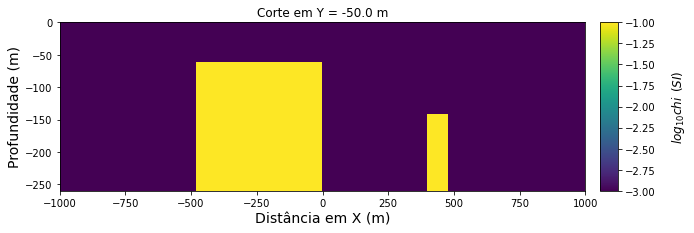

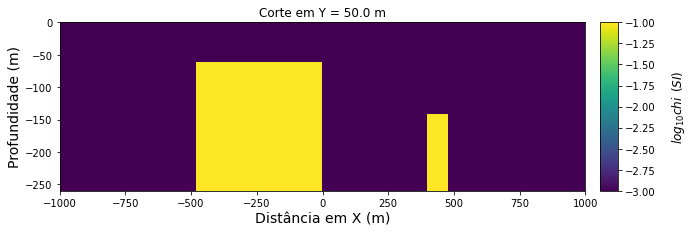

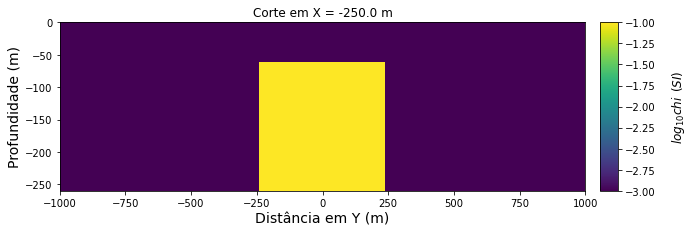

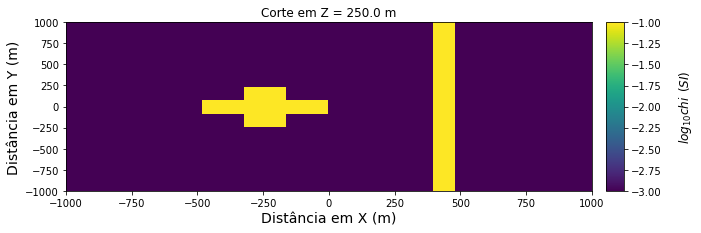

In [5]:
meu_modelo.plota_corte('Y', -50.0)
meu_modelo.plota_corte('Y', 50.0)
meu_modelo.plota_corte('X', -250.0)
meu_modelo.plota_corte('Z', 250.0)

### Passo 03 - Configuração da aquisição

Agora será preciso definir os parâmetros de aquisição de dados, i.e., os pontos onde serão realizadas as medidas de aceleração de gravidade sobre o modelo. Estes dados serão adquiridos em uma grade de pontos equiespaçados distribuídos na superfície do modelo, portanto será preciso definir os pontos inicial e final para o eixo X e para o eixo Y, assim como o número de pontos ao longo de cada direção.

A assinatura de uma anomalia magnética está sujeita às características de inclinação, declinação e intensidade do campo geomagnético na região onde a aquisição é feita, de forma que a anomalia observada sobre um mesmo corpo pode apresentar comportamentos diferentes em diferentes locais do mundo. Como padrão iremos definir as características do campo geomagnético nas coordenadas onde encontra-se o campus da Universidade Federal de Uberlândia em Monte Carmelo (latitude = -18.723889°, longitude = -47.523889°, altitude = 890.0 m) no dia 30/03/2021, data em que este notebook foi redigido. Características destas componentes para outras localidades podem ser obtidas a partir do [cálculo do IGRF](https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm).

Execute a célula abaixo para configurar estas características.

In [6]:
intensidade = 23170.0      # intensidade total em nT
inclinacao = -32.9445      # inclinação em graus
declinacao = -21.8288      # declinação em graus

Execute a célula abaixo para definir um levantamento realizado entre as coordenadas -1000.0 e 1000 do eixo X e entre as coordenadas -1000.0 e 1000.0 m do eixo Y, com 60 pontos de aquisição em cada direção. 

Esta simulação irá considerar também a altura do levantamento em 0.0 m, i.e., o levantamento será feito junto à superfície do modelo.

In [7]:
x_rx = np.linspace(-1000, 1000.0, 40)
y_rx = np.linspace(-1000.0, 1000.0, 40)
h_rx = 0.0

minha_aquisicao = aquisicao(x_rx, y_rx, h_rx, meu_modelo, \
                            f=intensidade, inc=inclinacao, dec=declinacao)

%time minha_aquisicao.fwd(meu_modelo)

Wall time: 1min 2s


### Mapa de intensidade do campo magnético total (TMI)

O mapa gerado pela simulação sobre o modelo corresponde ao conjunto de dados resultantes do procedimento de redução dos dados adquiridos em campo, que recebe o nome de mapa de intensidade de campo magnético total (TMI). Este mapa apresenta a anomalia dipolar causada pelo corpo imerso em um campo magnético externo.

Execute a célula abaixo para obter o mapa de TMI associado ao modelo configurado.

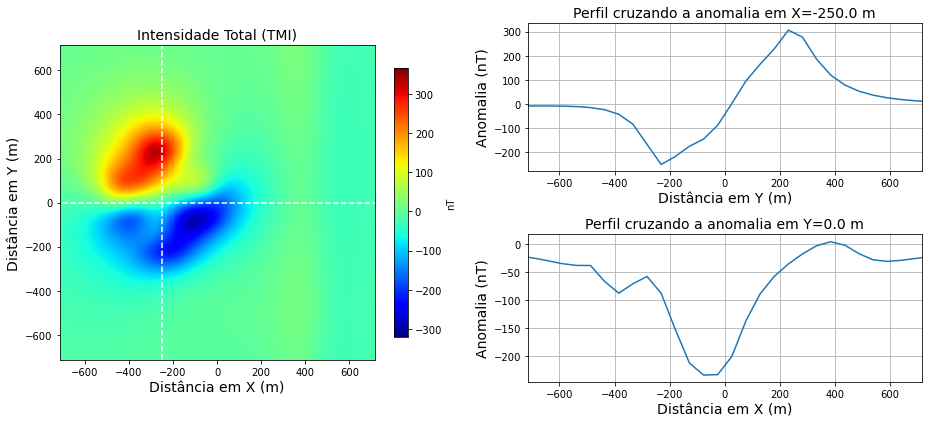

In [8]:
minha_aquisicao.plota_mapa([-250.0, 0.0])

# Transformações do campo

### Continuação para cima

A continuação para cima simula o efeito anômalo causado pelos contrastes de densidade em alturas diferentes daquela em que os dados foram adquiridos. Esta transformação atua sobre o datum onde os dados foram adquiridos deslocando-o para cima, daí o nome desta operação. Isto faz com que a influência das anomalias de curto comprimento de onda seja minimizada, enquanto as anomalias de longo comprimento de onda ainda continuam presentes no dado apresentando uma amplitude ligeiramente menor do que a amplitude original. Trata-se, portanto, de um tipo de filtragem que remove do dado as anomalias de curto comprimento de onda.

Existem duas aplicações principais para este tipo de procedimento: i) colocar diferentes conjuntos de dados em um mesmo datum para que sejam trabalhados em conjunto, como por exemplo quando se tem dados adquiridos em levantamentos aéreo e terrestre sobre uma mesma região, e ii) para estimar a influência do campo regional, que poderá ser utilizado para o cálculo do campo resitual.

No modelo utilizado neste notebook os dados foram adquiridos em terra ($h$ = 0.0 m). Execute a célula abaixo para transportar esta aquisição para uma altura de 500.0 m acima da superfície ($h$ = 500.0 m), obtendo assim um mapa de continuação para cima.

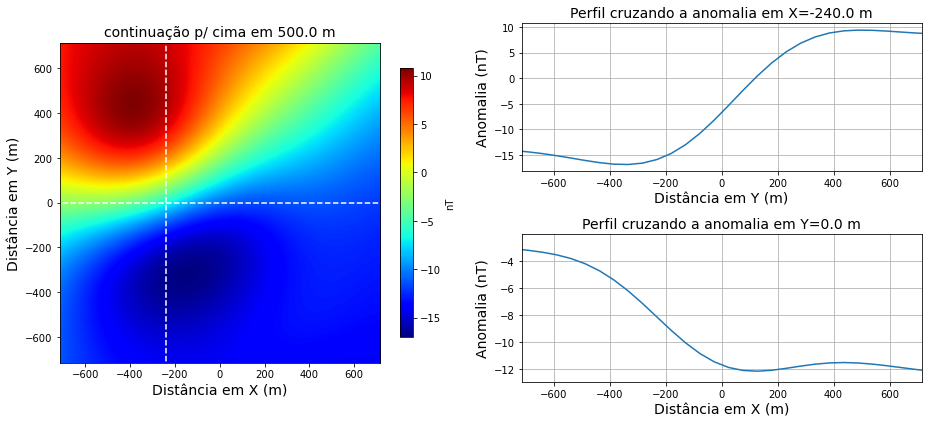

In [9]:
alt = 500.0        # altura da continuação (em metros)

minha_aquisicao_up = continuacao(minha_aquisicao, alt)
minha_aquisicao_up.plota_mapa([-240.0, 0.0])

### redução ao polo

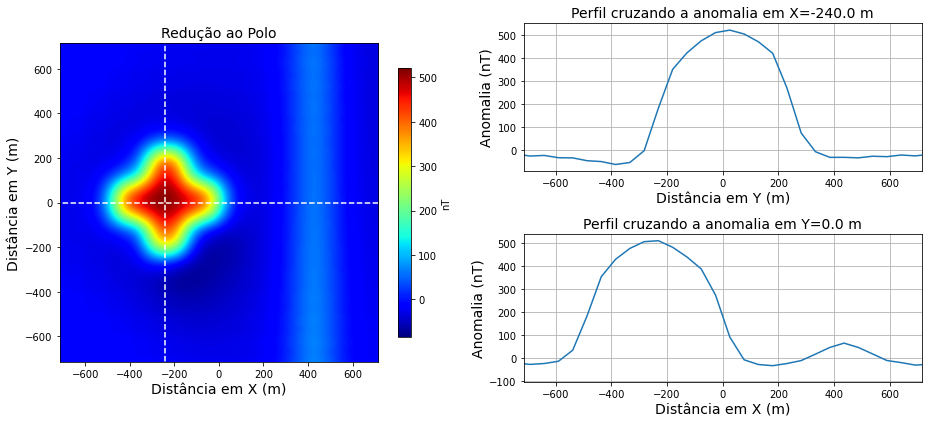

In [10]:
minha_aquisicao_rtp = red_polo(minha_aquisicao, inc=-35.9195, dec=-22.2848)
minha_aquisicao_rtp.plota_mapa([-240.0, 0.0])

### 2a derivada vertical

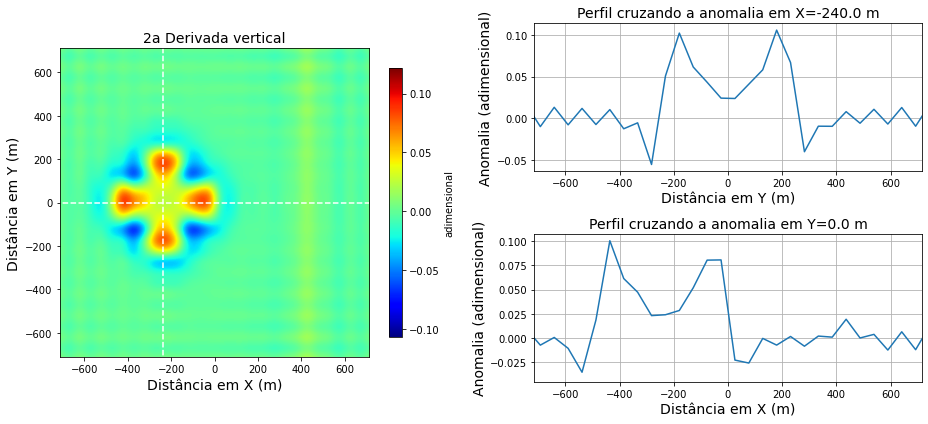

In [11]:
minha_aquisicao_dz2 = derivada_z(minha_aquisicao_rtp, ordem=2)
minha_aquisicao_dz2.plota_mapa([-240.0, 0.0])

### Amplitude do Gradiente Total (TGA)

O TGA é calculado por:

$$ TGA = \sqrt{\left(\frac{\partial f}{\partial x}\right)^2 + \left(\frac{\partial f}{\partial y}\right)^2 + \left(\frac{\partial f}{\partial z}\right)^2 } $$

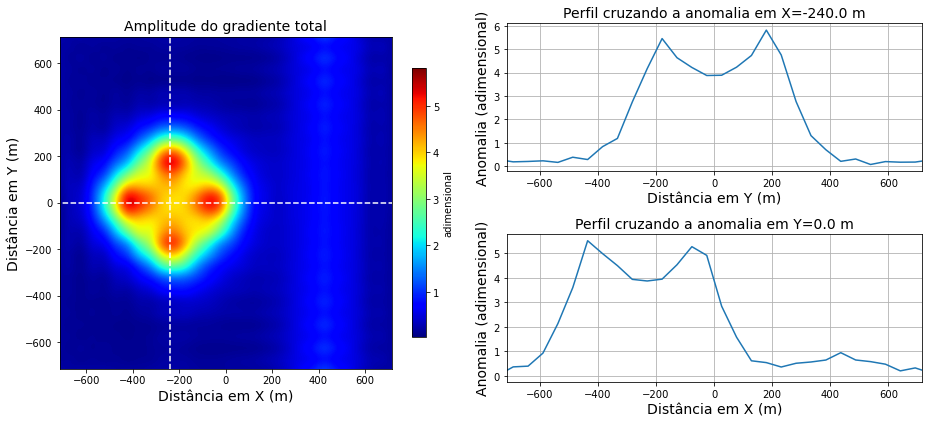

In [12]:
minha_aquisicao_tga = gradiente_total(minha_aquisicao_rtp)
minha_aquisicao_tga.plota_mapa([-240.0, 0.0])

### Derivada Tilt (T)

A Derivada Tilt é calculada por:

$$T = tan^{-1}\left(\frac{{\partial f / \partial z}}{\sqrt{({\partial f / \partial x})^2 + ({\partial f / \partial y})^2}}\right)$$

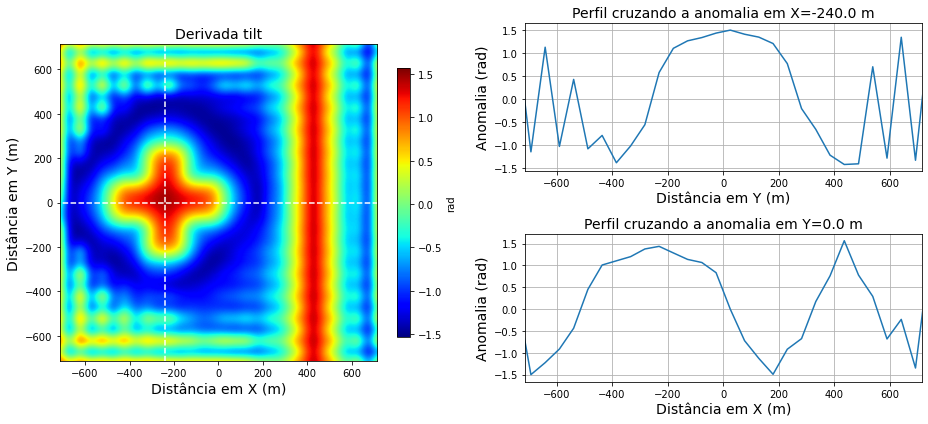

In [13]:
minha_aquisicao_tilt = derivada_tilt(minha_aquisicao_rtp)
minha_aquisicao_tilt.plota_mapa([-240.0, 0.0])

### Gradiente Horizontal Total (TDX)

O gradiente horizontal total permite evidenciar as bordas de um corpo em qualquer orientação, e é dado por (COOPER e COWAN, 2006):

$$fx_{tot} = \sqrt{\left(\frac{\partial f}{\partial x}\right)^2 + \left(\frac{\partial f}{\partial y}\right)^2}$$


Sendo mais comum o uso do gradiente normalizado pela amplitude da derivada vertical. Este gradiente normalizado é calculado por (COOPER e COWAN, 2006):

$$TDX = tan^{-1}\left(\frac{\sqrt{({\partial f / \partial x})^2 + ({\partial f / \partial y})^2}}{{|\partial f / \partial z|}}\right)$$

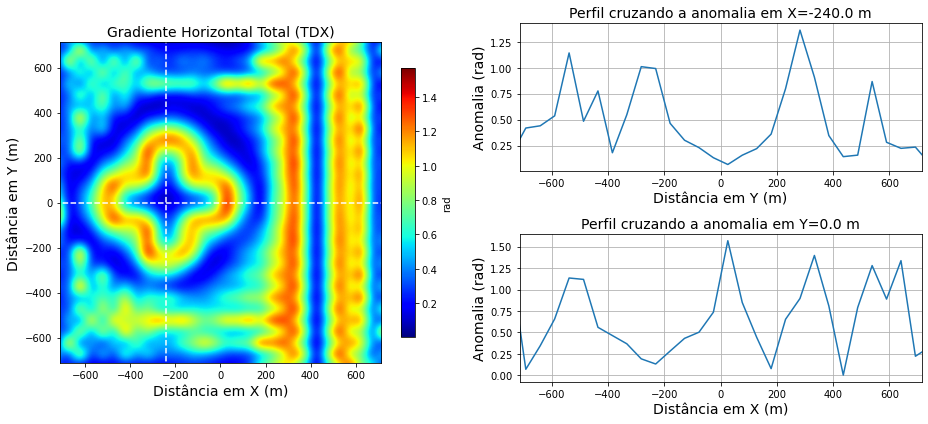

In [14]:
minha_aquisicao_tdx = tdx(minha_aquisicao_rtp)
minha_aquisicao_tdx.plota_mapa([-240.0, 0.0])

### Gradiente Horizontal Total da Derivada Tilt (THDR)

Verduzco et al. (2004)

$$THDR = \sqrt{\left(\frac{\partial T}{\partial x}\right)^2 + \left(\frac{\partial T}{\partial y}\right)^2}$$

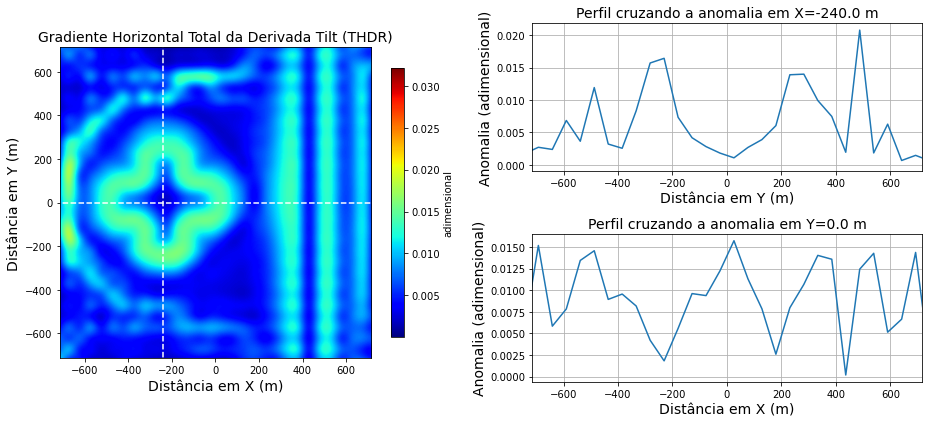

In [15]:
minha_aquisicao_thdr = thdr(minha_aquisicao_tilt)
minha_aquisicao_thdr.plota_mapa([-240.0, 0.0])

### T + TDX

Castro et al. (2018)

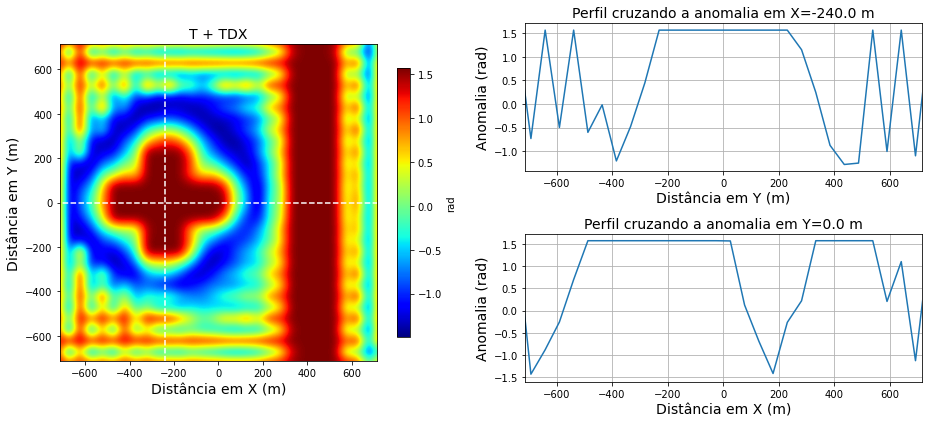

In [16]:
minha_aquisicao_tptdx = tptdx(minha_aquisicao_tilt, minha_aquisicao_tdx)
minha_aquisicao_tptdx.plota_mapa([-240.0, 0.0])

### T - TDX

Castro et al. (2018)

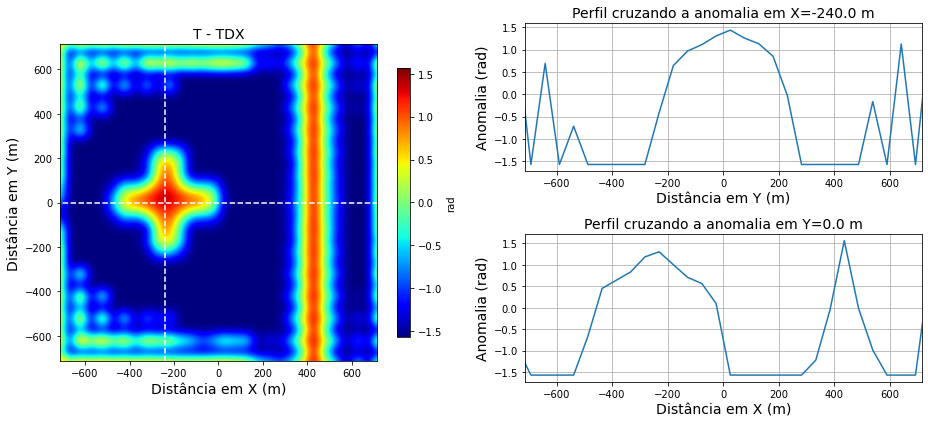

In [17]:
minha_aquisicao_tmtdx = tmtdx(minha_aquisicao_tilt, minha_aquisicao_tdx)
minha_aquisicao_tmtdx.plota_mapa([-240.0, 0.0])